
# Description
datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

# Evaluation

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE).

분류와 회귀중 회귀와 관련 된 문제 => 자전거 대여량을 예측하는 문제이기 때문에

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해/ seaborn은 matplot 라이브러리이 불러진 상태에서 작동하므로 세트로 같이 불러온다
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"]) #datetime 오브젝트로 변환하고자 하는 열의 이름을 전달하며 데이터를 불러올 때 datetime 오브젝트로 변환한다.
train.shape

(10886, 12)

In [3]:

# train.columns
# train.dtypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [4]:
train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
train.temp.describe()


count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [6]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [8]:
!pip install missingno

  Using cached missingno-0.5.0-py3-none-any.whl (8.8 kB)


<AxesSubplot:>

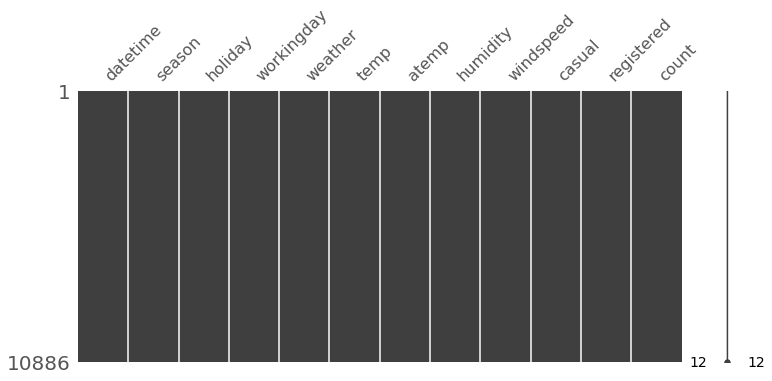

In [9]:
import missingno as msno

msno.matrix(train, figsize=(12,5))

In [10]:
# datetime 년,달,일.. 초으로 나누기
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train.shape

(10886, 18)

In [11]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

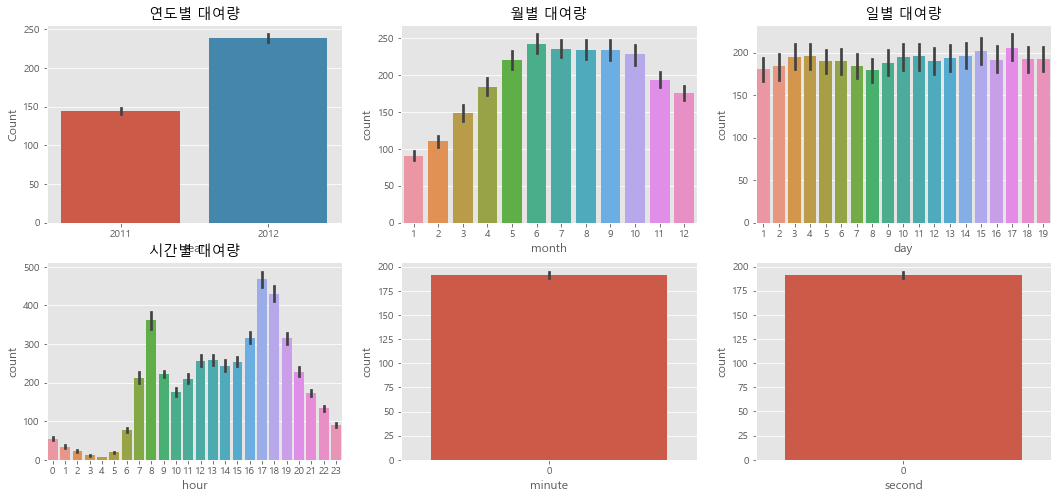

In [13]:
plt.rc('font', family='Malgun Gothic') #글자 깨짐 방지

figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3) # 다양한 그래프를 보고 싶다면 subplots 사용함
figure.set_size_inches(18,8)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)
sns.barplot(data=train, x="minute", y="count", ax=ax5)
sns.barplot(data=train, x="second", y="count", ax=ax6)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")

연도별 대여량은 2011년 보다 2012년이 더 많다.

월별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.

일별대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 피처로 사용하면 안 된다.

시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.

분, 초도 다 0이기 때문에 의미가 없다.

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

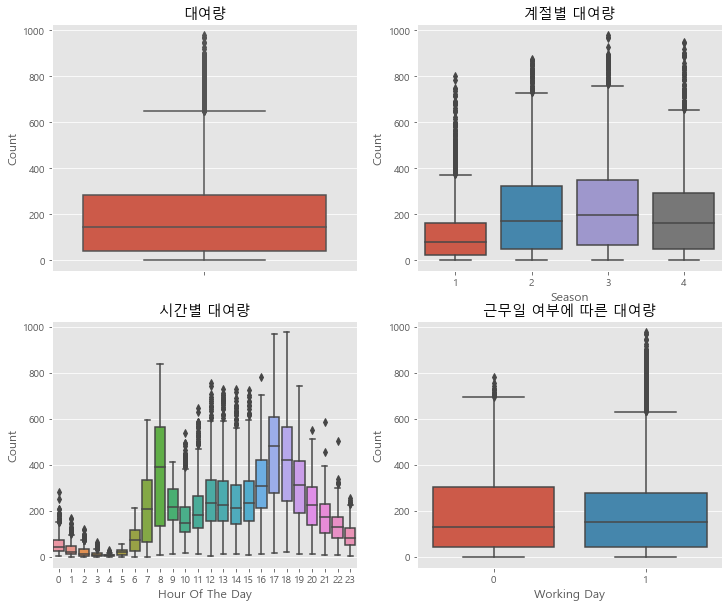

In [14]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="대여량")
axes[0][1].set(xlabel='Season', ylabel='Count',title="계절별 대여량")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="시간별 대여량")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="근무일 여부에 따른 대여량")

In [15]:
train["dayofweek"] = train["datetime"].dt.dayofweek    #https://zephyrus1111.tistory.com/69  참고
train.shape                 #월,화,수....,일 로 요일컬럼생성

(10886, 19)

In [16]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

<AxesSubplot:xlabel='hour', ylabel='count'>

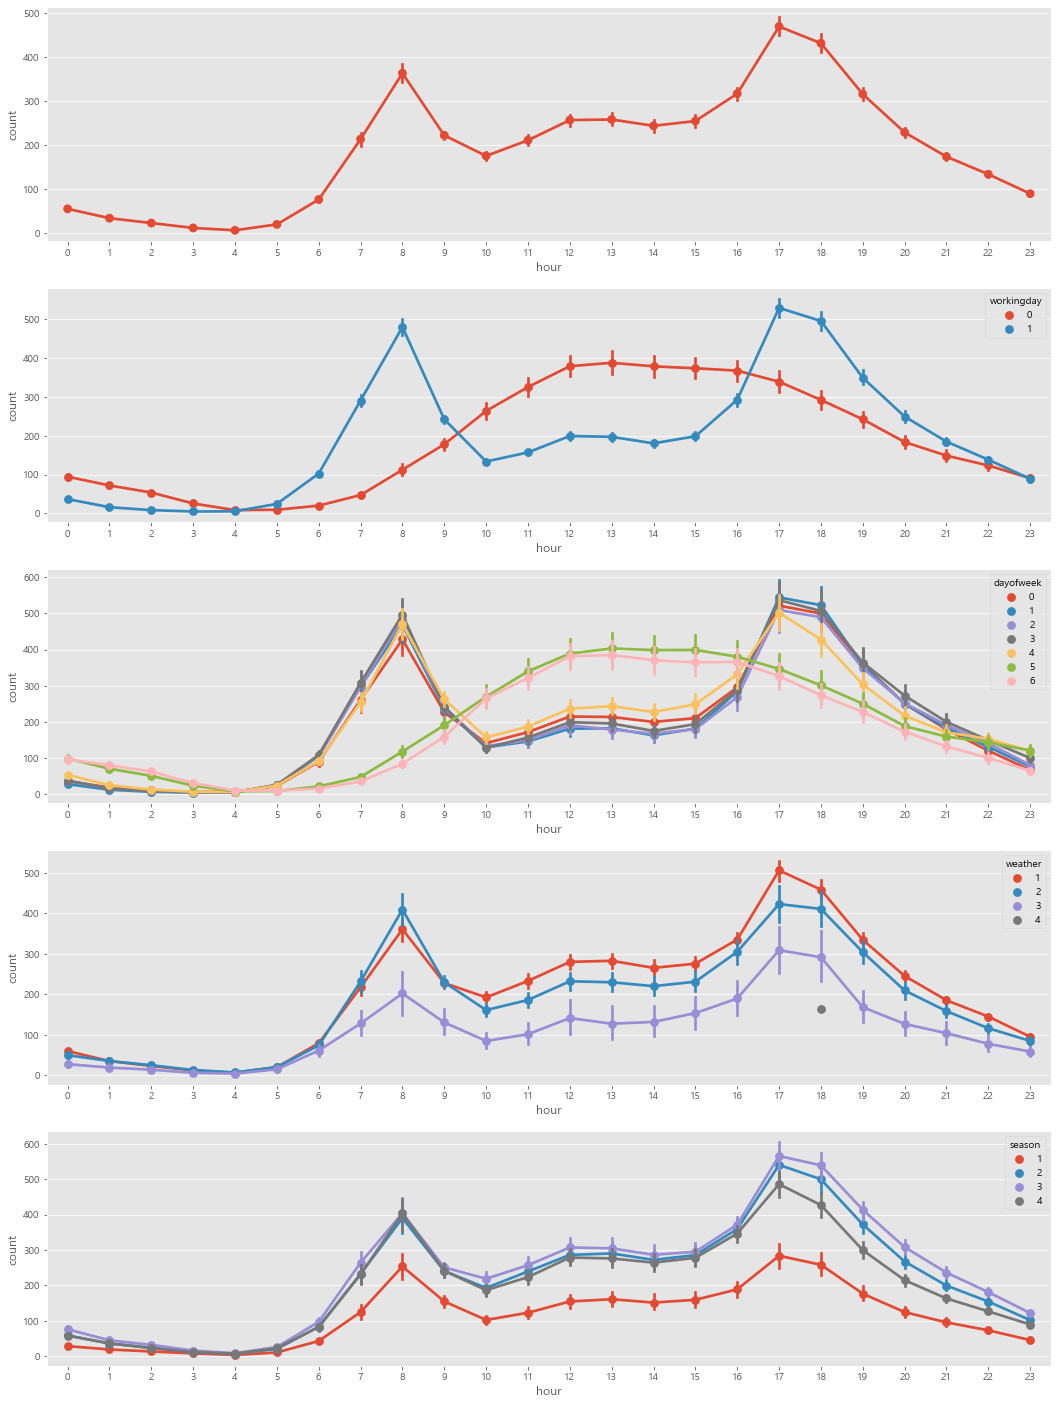

In [17]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)

sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)

sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)

sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

- season : 봄,여름,가을,겨울 순 / 가을에 가장 많이 자전거를 빌린다
- 출,퇴근 시간에 자전거를 많이 빌린다.

In [19]:

corrMatt = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot:>

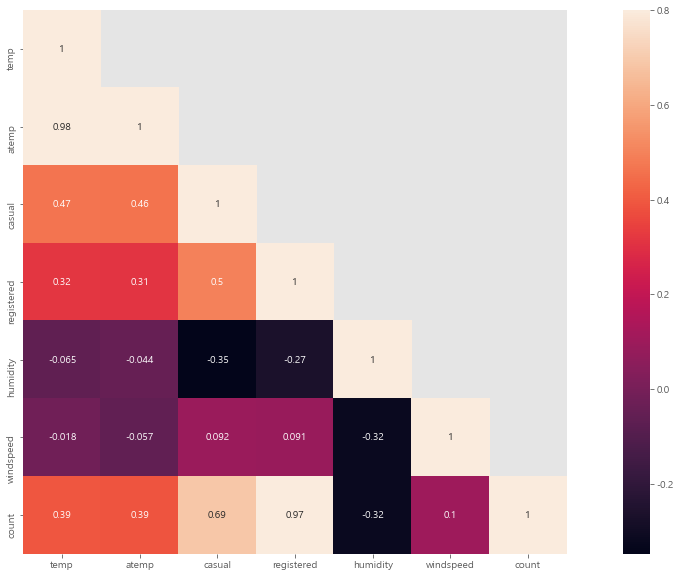

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

온도, 습도, 풍속은 거의 연관관계가 없다.

대여량과 가장 연관이 높은 건 registered 로 등록 된 대여자가 많지만, test 데이터에는 이 값이 없다.

atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다.

<AxesSubplot:xlabel='humidity', ylabel='count'>

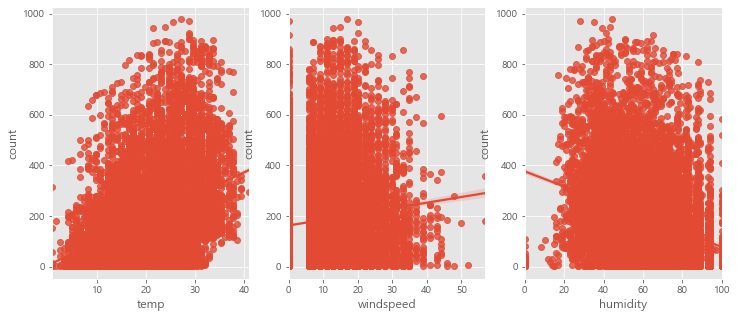

In [24]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=train,ax=ax2)
sns.regplot(x="humidity", y="count", data=train,ax=ax3)

- 풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다. 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.

In [26]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "year_month"]].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


In [27]:
train[["datetime", "year_month"]].tail()

,datetime,year_month
10881,2012-12-19 19:00:00,2012-12
10882,2012-12-19 20:00:00,2012-12
10883,2012-12-19 21:00:00,2012-12
10884,2012-12-19 22:00:00,2012-12
10885,2012-12-19 23:00:00,2012-12


<AxesSubplot:xlabel='year_month', ylabel='count'>

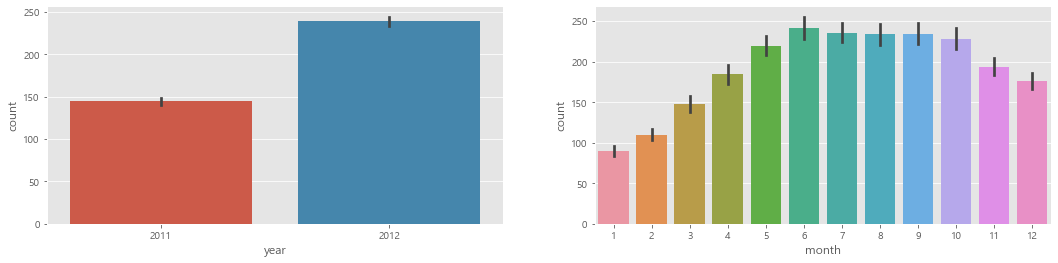

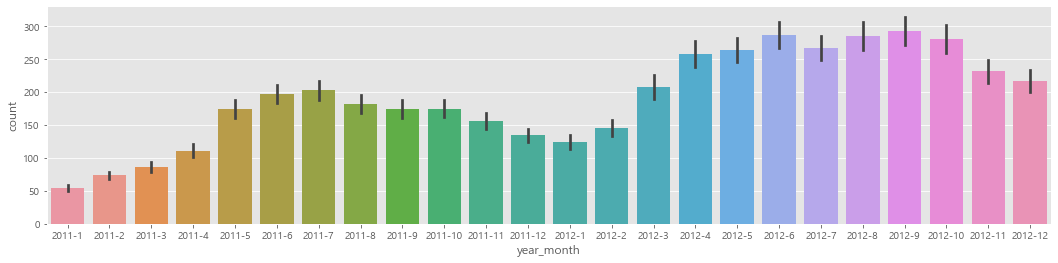

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year_month", y="count", ax=ax3)

- 2011년보다 2012년의 대여량이 더 많다.
- 겨울보다는 여름에 대여량이 많다.
- 2011년과 2012년의 월별 데이터를 이어보면 전체적으로 증가하는 추세이다.

In [29]:
# trainWithoutOutliers
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229778, 4.562423868087808, 0.9581176780909619))

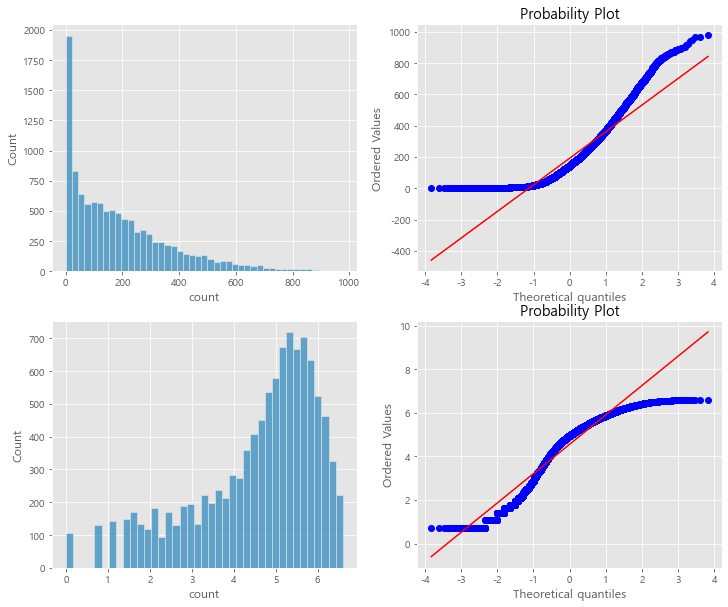

In [39]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.histplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.histplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])


count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.

